<a href="https://colab.research.google.com/github/jiwoong2/deeplearning/blob/main/Short_term_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module

In [ ]:
!pip install yfinance
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import yfinance as yf
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(DEVICE)

# Handle

In [ ]:
LR = 3e-5 # -1 인경우 한번에 0또는 1만 출력하는 로컬 미니멈으로 수렴.
EPOCH = 200
batch_size = 200 #데이터셋이 작은데 배치사이즈가 너무크면 문제가생김. 훈련 loss,와 검증 loss 역전, loss 하락폭 감소등 확인.
               #배치사이즈가 크면 gpu에 많은 data를 올릴 수 있어 훈련이 빨라지짐.
               #배치사이즈가 굉장히 중요한 역할을 하는듯. 이유를 알아보자.

# Short term model data

In [ ]:
def load_stock_data(Ticker, peri):

    ticker = yf.Ticker(Ticker)
    stock_data = ticker.history(period=peri)
    stock_data = stock_data.reset_index() # 인덱스 초기화
    stock_data.drop(['Date','Dividends','Stock Splits'], axis=1, inplace=True) # 불필요한 data 누락
    stock_data = stock_data.to_numpy()
    return stock_data

apple = load_stock_data("AAPL", "25y")
ms = load_stock_data("MSFT", "25y")
amz = load_stock_data("AMZN", "25y")
google = load_stock_data("GOOGL", "25y")
nv = load_stock_data("NVDA", "25y")
meta = load_stock_data("META", "25y")
nflx = load_stock_data("NFLX", "25y")

In [ ]:
# 로그변환.
# logged_close_prices = np.log(apple[:, 0:3])

# # 원본 배열에 로그 변환된 'Close' 가격을 다시 넣음
# apple[:, 0:3] = logged_close_prices

In [ ]:
# data, label생성기.
# Size:데이터개수.
# data:원본 data
# interval:시계열길이. ex) 30 -> 30일치 데이터를 보고 다음 5일간의 주가변동을 예측.
def data_generator(Size:int, data, interval:int):

    idx = np.random.choice(range(interval, len(data)-6), size=Size, replace=False)
    idx = np.array(idx)

    g_data = []
    g_label = []

    for i in idx:
        gs_data = data[i-interval:i, :]
        g_data.append(gs_data)

        label = (data[i+6,3] - data[i+1,3]) / data[i+1,3] * 100

        if  label >= 5:
            g_label.append(3)

        elif 0 <= label < 5:
            g_label.append(2)

        elif -5 <= label < 0:
            g_label.append(1)

        elif label < -5:
            g_label.append(0)

    g_data = np.array(g_data).astype(np.float32)
    g_label = np.array(g_label)

    return g_data, g_label

In [ ]:
apple_short_term_data, apple_short_term_label = data_generator(5000, apple, 20)
ms_short_term_data, ms_short_term_label = data_generator(5000, ms, 20)
amz_short_term_data, amz_short_term_label = data_generator(5000, amz, 20)
google_short_term_data, google_short_term_label = data_generator(4000, google, 20)
nv_short_term_data, nv_short_term_label = data_generator(5000, nv, 20)
meta_short_term_data, meta_short_term_label = data_generator(2000, meta, 20)
nflx_short_term_data, nflx_short_term_label = data_generator(5000, nflx, 20)

amz_short_term_data.shape

In [ ]:
short_term_data = np.concatenate((apple_short_term_data, ms_short_term_data, amz_short_term_data, google_short_term_data, nv_short_term_data,
                                  meta_short_term_data, nflx_short_term_data), axis=0)
short_term_label = np.concatenate((apple_short_term_label, ms_short_term_label, amz_short_term_label, google_short_term_label, nv_short_term_label,
                                   meta_short_term_label, nflx_short_term_label), axis=0)

In [ ]:
print(short_term_data.shape)
print(short_term_label.shape)

In [ ]:
# 데이터 표준화.
# 주가데이터는 지수적으로 증가하므로 각 샘플마다 따로 표준화함.
def data_scaler(data):
    for sample in range(data.shape[0]):
        scaler = StandardScaler()
        std = scaler.fit_transform(data[sample,:,:])
        data[sample,:,:] = std

data_scaler(short_term_data)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 인스턴스 생성.
short_term_dataset = CustomDataset(short_term_data, short_term_label)

#데이터를 훈련 데이터와 검증 데이터, 테스트 데이터로 나누기. 파이토치데이터셋 인스턴스에 사용하면 라벨도 같이 분류됨.
#훈련세트 80%, 테스트세트 20% 분류
train_size = int(0.9 * len(short_term_dataset))
test_size = len(short_term_dataset) - train_size

short_term_train_dataset, short_term_test_dataset = random_split(short_term_dataset, [train_size, test_size])

#테스트세트를 테스트세트 10%, 검증세트 10% 분류
test_size = int(0.5 * len(short_term_test_dataset))
val_size = len(short_term_test_dataset) - test_size

short_term_test_dataset, short_term_val_dataset = random_split(short_term_test_dataset, [test_size, val_size])

# 데이터 로더 생성.
short_term_train_DL = DataLoader(short_term_train_dataset, batch_size=batch_size, shuffle=True)
short_term_val_DL = DataLoader(short_term_val_dataset, batch_size=batch_size, shuffle=True)
short_term_test_DL = DataLoader(short_term_test_dataset, batch_size=batch_size, shuffle=True)

# 데이터 로더를 통해 데이터 확인
for features, labels in short_term_train_DL:
    print(features.shape)
    print(labels)
    break

In [ ]:
print(len(short_term_train_DL.dataset))
print(len(short_term_test_DL.dataset))
print(len(short_term_val_DL.dataset))

In [ ]:
sum(short_term_train_DL.dataset[:][1] == 0)

In [ ]:
class_counts = [sum(short_term_train_DL.dataset[:][1] == 0), sum(short_term_train_DL.dataset[:][1] == 1), sum(short_term_train_DL.dataset[:][1] == 2), sum(short_term_train_DL.dataset[:][1] == 3)]
total = sum(class_counts)
class_weights = [total / count for count in class_counts]
class_weights = torch.FloatTensor(class_weights)
print(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(DEVICE) # loss에 가중치를 부여하는경우 손실함수도 gpu에 올려야함.

# Short term model

In [ ]:
# class ShortTermModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.conv1 = nn.Sequential(nn.Conv2d(1, 20, 5, stride=1),
#                                    nn.BatchNorm2d(20),
#                                    nn.GELU())

#         self.conv2 = nn.Sequential(nn.Conv2d(1, 40, kernel_size=(20, 5), stride=1),
#                                    nn.BatchNorm2d(40),
#                                    nn.GELU())

#         self.conv3 = nn.Sequential(nn.Conv2d(1, 80, kernel_size=(40, 5), stride=1),
#                                    nn.BatchNorm2d(80),
#                                    nn.GELU())

#         self.conv4 = nn.Sequential(nn.Conv2d(1, 160, kernel_size=(80, 5), stride=1),
#                                    nn.BatchNorm2d(160),
#                                    nn.GELU())

#         self.linear = nn.Sequential(nn.Linear(640,100), nn.GELU(),
#                                     nn.Linear(100,4))

#     def forward(self, x):

#         x = x.permute(0,2,1)
#         x = x.unsqueeze(1)
#         x = self.conv1(x)
#         x = x.squeeze().unsqueeze(1)
#         x = self.conv2(x)
#         x = x.squeeze().unsqueeze(1)
#         x = self.conv3(x)
#         x = x.squeeze().unsqueeze(1)
#         x = self.conv4(x)
#         x = x.squeeze().unsqueeze(1)
#         x = torch.flatten(x, start_dim=1)
#         x = self.linear(x)

#         return x

# model = ShortTermModel().to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr = LR)

In [ ]:
class ShortTermModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(1, 5, 5, stride=1),
                                   nn.BatchNorm2d(5),
                                   nn.GELU())

        self.conv2 = nn.Sequential(nn.Conv2d(1, 10, kernel_size=(5, 5), stride=1),
                                   nn.BatchNorm2d(10),
                                   nn.GELU())

        self.conv3 = nn.Sequential(nn.Conv2d(1, 20, kernel_size=(10, 5), stride=1),
                                   nn.BatchNorm2d(20),
                                   nn.GELU())

        self.conv4 = nn.Sequential(nn.Conv2d(1, 40, kernel_size=(20, 5), stride=1),
                                   nn.BatchNorm2d(40),
                                   nn.GELU())

        self.linear = nn.Sequential(nn.Linear(160,4))

    def forward(self, x):

        x = x.permute(0,2,1)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = x.squeeze().unsqueeze(1)
        x = self.conv2(x)
        x = x.squeeze().unsqueeze(1)
        x = self.conv3(x)
        x = x.squeeze().unsqueeze(1)
        x = self.conv4(x)
        x = x.squeeze().unsqueeze(1)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)

        return x

model = ShortTermModel().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LR)

In [ ]:
# for i in short_term_train_DL:
#     test_data = i[0]
#     break

# test_data.shape

In [ ]:
# model = ShortTermModel()
# a = model(test_data)
# print(a.shape)

# Trainer

In [ ]:
# 1에폭 트레이닝.
def loss_epoch(model, DL, criterion, optimizer = None):

    N = len(DL.dataset) # the number of data
    rloss = 0; rcorrect = 0

    for x_batch, y_batch in DL:

        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        # inference
        y_hat = model(x_batch)

        # loss
        loss = criterion(y_hat,y_batch)

        # update
        if optimizer is not None:
            optimizer.zero_grad() # gradient 누적을 막기 위한 초기화
            loss.backward() # backpropagation
            optimizer.step() # weight update

        # loss accumulation
        loss_b = loss.item() * x_batch.shape[0] # batch loss # BATCH_SIZE를 곱하면 마지막 18개도 32개를 곱하니까..
        rloss += loss_b # running loss
        # accuracy accumulation
        pred = y_hat.argmax(dim=1)
        corrects_b = torch.sum(pred == y_batch).item()
        rcorrect += corrects_b

    loss_e = rloss/ N # epoch loss
    accuracy_e = rcorrect/N*100

    return loss_e, accuracy_e, rcorrect

def Train(model, train_DL, val_DL, criterion, optimizer, EPOCH):

    loss_history = {"train":[], "val":[]}
    acc_history = {"train":[], "val":[]}

    for ep in tqdm(range(EPOCH), leave=False):

        model.train() # train mode로 전환
        train_loss, train_acc, _ = loss_epoch(model, train_DL, criterion, optimizer)
        loss_history["train"] += [train_loss]
        acc_history["train"] += [train_acc]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss, val_acc, _ = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            acc_history["val"] += [val_acc]

        # # print loss
        # print(f"train loss: {round(train_loss,5)}, "
        #       f"val loss: {round(val_loss,5)} \n"
        #       f"train acc: {round(train_acc,1)} %, "
        #       f"val acc: {round(val_acc,1)} %, time: {round(time.time()-epoch_start)} s")
        # print("-"*20)

    return loss_history, acc_history

def Test(model, test_DL, criterion):
    model.eval()
    with torch.no_grad():
        test_loss, test_acc, rcorrect = loss_epoch(model, test_DL, criterion)
    print()
    print(f"Test loss: {round(test_loss,5)}")
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(test_acc,1)} %)")
    return round(test_acc,1)

def graph(loss, acc, epoch):
    # 두 개의 그래프를 하나의 figure에 가로로 배열
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # 첫 번째 그래프 (Train Loss와 Validation Loss)
    axs[0].plot(range(1, epoch + 1), loss['train'], label='Train Loss')
    axs[0].plot(range(1, epoch + 1), loss['val'], label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].legend()

    # 두 번째 그래프 (Train Accuracy와 Validation Accuracy)
    axs[1].plot(range(1, epoch + 1), acc['train'], label='Train acc')
    axs[1].plot(range(1, epoch + 1), acc['val'], label='Validation acc')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].legend()

    # 그래프 출력
    plt.tight_layout()  # 그래프 간격 조정
    plt.show()

# Experience

In [ ]:
loss, acc = Train(model, short_term_train_DL, short_term_val_DL, criterion, optimizer, EPOCH)

In [ ]:
graph(loss, acc, EPOCH)

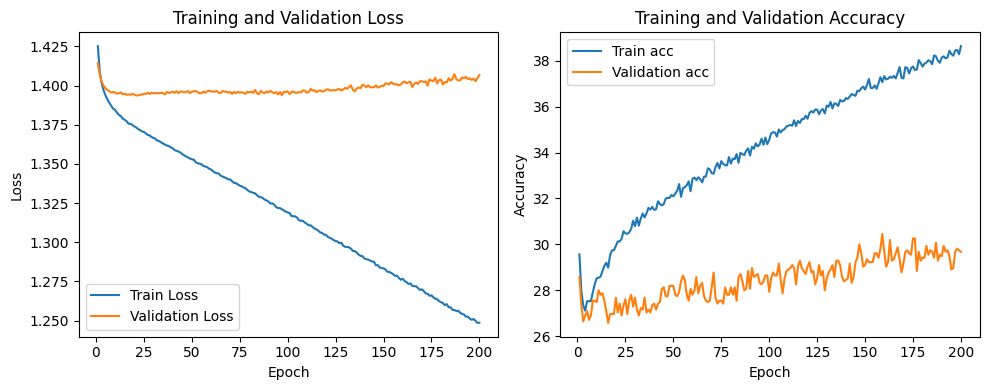

위가 데이터를 늘린결과.

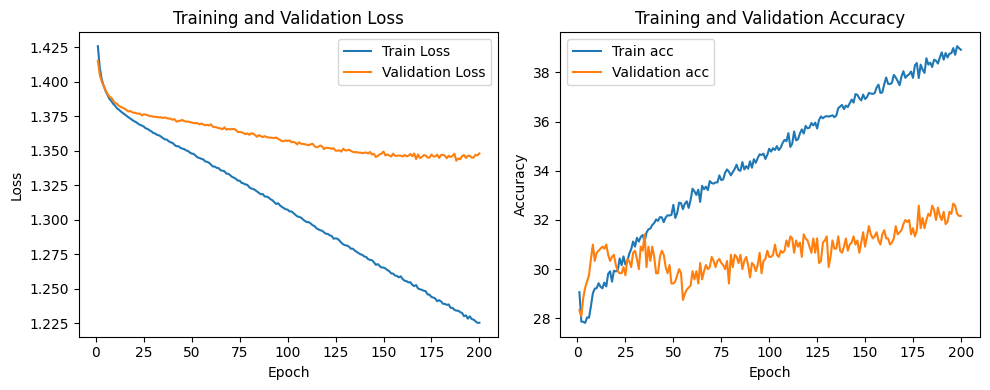

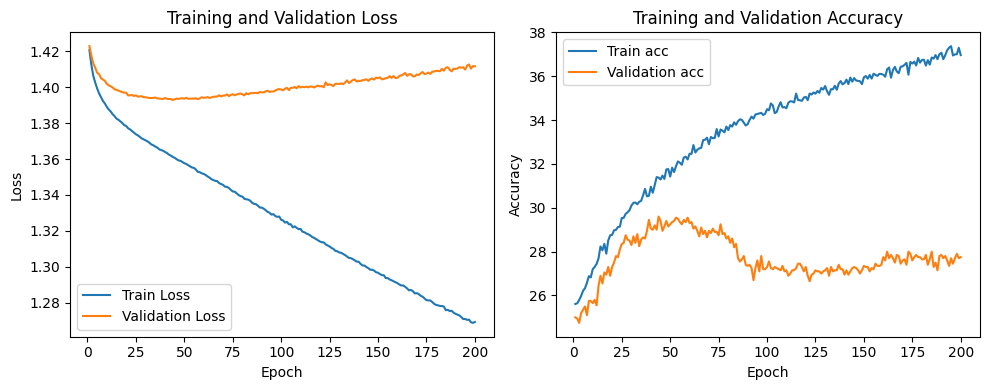

In [ ]:
Test(model, short_term_test_DL, criterion)

In [ ]:
print(sum(short_term_test_DL.dataset[:][1]==0)/short_term_test_DL.dataset[:][1].size*100)
print(sum(short_term_test_DL.dataset[:][1]==1)/short_term_test_DL.dataset[:][1].size*100)
print(sum(short_term_test_DL.dataset[:][1]==2)/short_term_test_DL.dataset[:][1].size*100)
print(sum(short_term_test_DL.dataset[:][1]==3)/short_term_test_DL.dataset[:][1].size*100)

# Model save

In [ ]:
#전체 모델 저장하기
#torch.save(model, '/content/drive/MyDrive/Colab Notebooks/results/short_term_model.pt')

# # 나중에 전체 모델 로드하기
# model = torch.load('model_complete.pth')
# model.eval()  # 추론 모드로 설정